# E_nr Notebook

# Input Cell: Modify and Hit 'Run All', and check C:\ACME_Zhen_Code\Enr

In [19]:

binpara = {
  "bin_size": 70,
  "bin_offset": 26
}

run = 15
sequence = 1336
NAS_drive_name = r"L:\ACME 3 EDM Data"
folder_path = r"C:\ACME_Zhen_Code\Enr\Enr_" + str(run).zfill(4) + "." + str(sequence).zfill(4)

print("results are saved at:", folder_path)

results are saved at: C:\ACME_Zhen_Code\Enr\Enr_0015.1336


In [20]:
import json
import os
import pickle
import numpy as np
from numba import jit, prange
import math
import matplotlib.pyplot as plt
import pandas as pd
import re
import glob
import os
from datetime import datetime
import shutil
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle


class binCalculator:
    class Parameters:
        def __init__(self, parent):
            self.name = None
            self.parent = parent
            self.bin_mask = (0, 0, 0, 0)
            self.bin_size = 50
            self.bin_offset = 0
            self.background_begin_time_ms = 0
            self.background_end_time_ms = 0.5
            self.background_average_level = '4trace'
            self.background_D_mode = 'equal'
            self.noisechannel_substraction = False
            self.noisechannel = []
            self.group_size = 20
            self.sum_shot = True
            self.sum_channel = False
            self.ACMEIII_header_purge = True
            self.file_dtype = 'int16'
            self.trace_already_summed = True
            self.channel_weight =[-0.03963429, -0.03918644, -0.03918644, -0.04009249, -0.03986207,
       -0.03853333, -0.0387486 , -0.0387486]
            self.total_timestamps = 175000
            self.info_header_length = 4

        def _load_parameters_from_json(self, parameter_file_path):
            try:
                with open(parameter_file_path, 'r') as f:
                    param_dict = json.load(f)
                
                for key, value in param_dict.items():
                    if hasattr(self, key) and value is not None:
                        setattr(self, key, value)
            except FileNotFoundError:
                print(f"Parameter file {parameter_file_path} not found, using default values.")
            except json.JSONDecodeError:
                print(f"Error decoding JSON file {parameter_file_path}, using default values.")
            except Exception as e:
                print(f"Unexpected error: {e}")

    class BinResults:
        def __init__(self):
            self.name = None
            self.A = None
            self.N = None
            self.dA2_from_photon = None
            self.dA2_from_fitting = None
            self.chi_square = None
            self.red_chi_square = None
            self.N0 = None
            self.A0 = None
            self.N1 = None
            self.A1 = None
            self.shot_yield = None
            self.e_A = None
            self.e_N = None
            self.bin_pair_inspection_data = None
            self.x_mask = None  # pre swap x_mask
            self.y_mask = None # pre swap y_mask
            self.swap_xy = None
            self.F = None
            self.Fx = None
            self.Fy = None

    def __init__(self, binary_file_path, parameter_file_path, df_slice):
        # Initialization
        self.raw_data = None
        self.data = None
        self.name = None
        self.file_name = None
        self.background_subtracted_data = None
        self.ungrouped_Fx = None
        self.ungrouped_Fy = None
        self.ungrouped_N_total = None
        self.ungrouped_asymmetry = None
        self.grouped_Fx = None
        self.grouped_Fy =  None
        self.grouped_F = None  # Fx - Fy
        self.grouped_N_total = None
        self.grouped_asymmetry = None
        self.ungrouped_Fx_before_substraction = None
        self.ungrouped_Fy_before_substraction = None
        self.df = df_slice
        self.binary_file_path = binary_file_path
        self.parameter_file_path = parameter_file_path
        self.binresult = self.BinResults()
        self.parameter = self.Parameters(self)
        self.parameter._load_parameters_from_json(self.parameter_file_path)
        try:
            self.swap_xy = False if self.df['Polarization Switching XY Swapped'].dropna().mode()[0] == 0 else True
        except:
            self.swap_xy = False
        self.binresult.swap_xy = self.swap_xy
        # print('swap_xy', self.swap_xy)
    
    def default_pipeline(self):
        # 1. Load the binary data
        self._load_binary_data(time_total_timestamps=self.parameter.total_timestamps)

        self._photon_conversion()

        self._apply_binning(time_total_timestamps=self.parameter.total_timestamps)

        self._calculate_Fx_Fy()

        self._bg_substraction()

        self._calculate_asymmetry()

        self._group_asymmetry()

        self._group_linear_fit()

        self._chi_square()

        self._calculate_shot_yield()

    def smooth_data_step(data, step_size=5):
        smoothed_data = np.array([
            np.mean(data[max(0, i - step_size // 2):min(len(data), i + step_size // 2 + 1)]) 
            for i in range(len(data))
        ])
        return smoothed_data

    def _load_binary_data(self, time_total_timestamps = 175000):
        """ load in the binary file as unbinned data (before scaling to photon number) into self.raw_data """
        def _header_purging(data,info_header_length = 4,channel_total_number = 8, time_total_timestamps= time_total_timestamps):
            reshaped_data = data.reshape(-1,info_header_length+channel_total_number*time_total_timestamps)
            truncated_segments = reshaped_data[:, info_header_length:]
            purged_data = truncated_segments.flatten()
            return purged_data

        def _fluorescent_to_data(data, purge = True, trace_already_summed = True, info_header_length = 4, time_total_timestamps = time_total_timestamps):
            channel_total_number = 8
            time_total_timestamps = time_total_timestamps
            if purge == True:
                shot_number = int(len(data)/(channel_total_number*time_total_timestamps+ info_header_length))
                purged_data = _header_purging(data, info_header_length=info_header_length, time_total_timestamps=time_total_timestamps)
            else:
                shot_number = int(len(data)/(channel_total_number*time_total_timestamps))
                purged_data = data
            if trace_already_summed is False:
                trace_number = shot_number//25
                mat = purged_data.reshape(trace_number, 25 , channel_total_number,-1)
            else:
                trace_number = shot_number
                mat = purged_data.reshape(trace_number, 1 , channel_total_number, -1)
            return mat

        if self.parameter.file_dtype == 'int16':
            dtype = np.int16
        elif self.parameter.file_dtype == 'int32':
            dtype = np.int32
        elif self.parameter.file_dtype == 'float32':
            dtype = np.float32
        elif self.parameter.file_dtype == 'float64':
            dtype = np.float64

        with open(self.binary_file_path, "rb") as file:
            self.data = np.fromfile(self.binary_file_path, dtype=dtype)
        self.file_name = os.path.basename(self.binary_file_path)
        self.name, _ = os.path.splitext(self.file_name)
        self.binresult.name = self.name
        self.raw_data = _fluorescent_to_data(self.data, self.parameter.ACMEIII_header_purge, self.parameter.trace_already_summed, self.parameter.info_header_length, time_total_timestamps=self.parameter.total_timestamps)
        self.raw_data = self.raw_data.astype(np.float64)

    def _photon_conversion(self):
        self.data = self.raw_data*(np.array(self.parameter.channel_weight).reshape(1,1,8,1))

    def _apply_binning(self, time_total_timestamps = 175000):
        bin_offset = self.parameter.bin_offset
        while bin_offset<0:
            bin_offset = bin_offset + self.parameter.bin_size
        while bin_offset>=self.parameter.bin_size:
            bin_offset = bin_offset - self.parameter.bin_size
        adjusted_size = time_total_timestamps - (time_total_timestamps - bin_offset) % self.parameter.bin_size
        if self.parameter.trace_already_summed is False:
            self.binned_data = self.data[:,:,:,bin_offset:adjusted_size].reshape(self.data.shape[0],25,8,-1,self.parameter.bin_size)
        else:
            self.binned_data = self.data[:,:,:,bin_offset:adjusted_size].reshape(self.data.shape[0],1,8,-1,self.parameter.bin_size)

    def _calculate_Fx_Fy(self):
        def _generate_mask(x_gap_left=0,x_gap_right=0,y_gap_left=0,y_gap_right=0,bin_size=50, swap_xy = False):
            x_mask = np.concatenate([np.zeros(x_gap_left),np.ones(bin_size//2-x_gap_left-x_gap_right),np.zeros(x_gap_right),np.zeros(bin_size//2)])
            y_mask = np.concatenate([np.zeros(bin_size//2),np.zeros(y_gap_left),np.ones(bin_size//2-y_gap_left-y_gap_right),np.zeros(y_gap_right)])
            if swap_xy:
                return y_mask,x_mask
            return x_mask,y_mask

        # Use the bin_mask to separate Fx and Fy from data
        x_mask, y_mask = _generate_mask(*self.parameter.bin_mask, self.parameter.bin_size, self.swap_xy)
        self.binresult.x_mask = x_mask
        self.binresult.y_mask = y_mask
        ungrouped_Fx = np.tensordot(self.binned_data, x_mask, axes=([4], [0]))
        ungrouped_Fy = np.tensordot(self.binned_data, y_mask, axes=([4], [0]))

        if self.parameter.sum_shot:
            ungrouped_Fx = ungrouped_Fx.sum(axis = (1),keepdims = True)
            ungrouped_Fy = ungrouped_Fy.sum(axis = (1),keepdims = True)
        if self.parameter.sum_channel:
            ungrouped_Fx = ungrouped_Fx.sum(axis = (2),keepdims = True)
            ungrouped_Fy = ungrouped_Fy.sum(axis = (2),keepdims = True)

        self.ungrouped_Fx_before_substraction = ungrouped_Fx
        self.ungrouped_Fy_before_substraction = ungrouped_Fy
        
        if self.parameter.noisechannel_substraction:
            if len(self.parameter.noisechannel) > 0:
                background_channel = self.parameter.noisechannel
                remaining_channel = [i for i in range(8) if i not in background_channel]
                predicted_bg = np.zeros(self.ungrouped_Fy_before_substraction.mean(axis = 2, keepdims = True).shape)
                for trace in range(self.ungrouped_Fy_before_substraction.shape[0]):
                    for shot in range(self.ungrouped_Fy_before_substraction.shape[1]):
                        if len(background_channel) > 1:
                            predicted_bg[trace, shot, 0 , :] = (binCalculator.smooth_data_step(self.ungrouped_Fy_before_substraction[trace, shot, background_channel, :].mean(axis = 0), 300) + binCalculator.smooth_data_step(self.ungrouped_Fx_before_substraction[trace, shot, background_channel, :].mean(axis = 0), 300))/2.0
                        else:
                            predicted_bg[trace, shot, 0 , :] = (binCalculator.smooth_data_step(self.ungrouped_Fy_before_substraction[trace, shot, background_channel[0], :], 300) + binCalculator.smooth_data_step(self.ungrouped_Fx_before_substraction[trace, shot, background_channel[0], :], 300))/2.0
                self.ungrouped_Fx_before_substraction = self.ungrouped_Fx_before_substraction[:,:,remaining_channel,:] - predicted_bg
                self.ungrouped_Fy_before_substraction = self.ungrouped_Fy_before_substraction[:,:,remaining_channel,:] - predicted_bg
        else:
            if len(self.parameter.noisechannel) > 0:
                background_channel = self.parameter.noisechannel
                remaining_channel = [i for i in range(8) if i not in background_channel]
                self.ungrouped_Fx_before_substraction = self.ungrouped_Fx_before_substraction[:,:,remaining_channel,:]
                self.ungrouped_Fy_before_substraction = self.ungrouped_Fy_before_substraction[:,:,remaining_channel,:]
            
    def _bg_substraction(self):
        background_begin_bin_index = int(math.floor((self.parameter.background_begin_time_ms*1000000//80)//self.parameter.bin_size))
        background_end_bin_index = int(math.floor((self.parameter.background_end_time_ms*1000000//80)//self.parameter.bin_size))

        if self.parameter.background_average_level == 'shot':
            bgx = self.ungrouped_Fx_before_substraction[:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = 3, keepdims = True).repeat(self.ungrouped_Fx_before_substraction.shape[3],axis = 3)
            bgy = self.ungrouped_Fy_before_substraction[:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = 3, keepdims = True).repeat(self.ungrouped_Fy_before_substraction.shape[3],axis = 3)
        if self.parameter.background_average_level == 'trace':
            bgx = self.ungrouped_Fx_before_substraction[:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,3), keepdims = True).repeat(self.ungrouped_Fx_before_substraction.shape[1],axis = 1).repeat(self.ungrouped_Fx_before_substraction.shape[3],axis = 3)
            bgy = self.ungrouped_Fy_before_substraction[:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,3), keepdims = True).repeat(self.ungrouped_Fy_before_substraction.shape[1],axis = 1).repeat(self.ungrouped_Fy_before_substraction.shape[3],axis = 3)
        if self.parameter.background_average_level == 'block':
            bgx = self.ungrouped_Fx_before_substraction[:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (0,1,3), keepdims = True).repeat(self.ungrouped_Fx_before_substraction.shape[0],axis = 0).repeat(self.ungrouped_Fx_before_substraction.shape[1],axis = 1).repeat(self.ungrouped_Fx_before_substraction.shape[3],axis = 3)
            bgy = self.ungrouped_Fy_before_substraction[:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (0,1,3), keepdims = True).repeat(self.ungrouped_Fy_before_substraction.shape[0],axis = 0).repeat(self.ungrouped_Fy_before_substraction.shape[1],axis = 1).repeat(self.ungrouped_Fy_before_substraction.shape[3],axis = 3)
        if self.parameter.background_average_level == 'none':
            bgx = 0
            bgy = 0
        if self.parameter.background_average_level == '2trace':
            bgx = self.ungrouped_Fx_before_substraction.reshape(-1,2,*self.ungrouped_Fx_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(2,axis = 1).repeat(self.ungrouped_Fx_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fx_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fx_before_substraction.shape)
            bgy = self.ungrouped_Fy_before_substraction.reshape(-1,2,*self.ungrouped_Fy_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(2,axis = 1).repeat(self.ungrouped_Fy_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fy_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fy_before_substraction.shape)
        if self.parameter.background_average_level == '4trace':
            bgx = self.ungrouped_Fx_before_substraction.reshape(-1,4,*self.ungrouped_Fx_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(4,axis = 1).repeat(self.ungrouped_Fx_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fx_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fx_before_substraction.shape)
            bgy = self.ungrouped_Fy_before_substraction.reshape(-1,4,*self.ungrouped_Fy_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(4,axis = 1).repeat(self.ungrouped_Fy_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fy_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fy_before_substraction.shape)
        if self.parameter.background_average_level == '8trace':
            bgx = self.ungrouped_Fx_before_substraction.reshape(-1,8,*self.ungrouped_Fx_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(8,axis = 1).repeat(self.ungrouped_Fx_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fx_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fx_before_substraction.shape)
            bgy = self.ungrouped_Fy_before_substraction.reshape(-1,8,*self.ungrouped_Fy_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(8,axis = 1).repeat(self.ungrouped_Fy_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fy_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fy_before_substraction.shape)
        if self.parameter.background_average_level == '16trace':
            bgx = self.ungrouped_Fx_before_substraction.reshape(-1,16,*self.ungrouped_Fx_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(16,axis = 1).repeat(self.ungrouped_Fx_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fx_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fx_before_substraction.shape)
            bgy = self.ungrouped_Fy_before_substraction.reshape(-1,16,*self.ungrouped_Fy_before_substraction.shape[1:])[:,:,:,:,background_begin_bin_index:background_end_bin_index].mean(axis = (1,2,4), keepdims = True).repeat(16,axis = 1).repeat(self.ungrouped_Fy_before_substraction.shape[1],axis = 2).repeat(self.ungrouped_Fy_before_substraction.shape[3],axis = 4).reshape(self.ungrouped_Fy_before_substraction.shape)
            
        if self.parameter.background_D_mode == 'equal':
            bg = (bgx + bgy) / 2.0
            bgx = bg
            bgy = bg

        self.bgx = bgx
        self.bgy = bgy
        self.ungrouped_Fx = self.ungrouped_Fx_before_substraction - bgx
        self.ungrouped_Fy = self.ungrouped_Fy_before_substraction - bgy

        # for bin_pair_inspection_slice
        bgz = self.binned_data[:,:,:,background_begin_bin_index:background_end_bin_index,:].mean(axis = (1,3), keepdims = True).repeat(self.binned_data.shape[1],axis = 1).repeat(self.binned_data.shape[3],axis = 3)
        self.binresult.bin_pair_inspection_data = (self.binned_data - bgz).mean(axis = (0,1,2))

    def _calculate_asymmetry(self):
        self.ungrouped_N_total = self.ungrouped_Fx + self.ungrouped_Fy
        self.ungrouped_asymmetry = (self.ungrouped_Fx - self.ungrouped_Fy) / self.ungrouped_N_total

    def _group_asymmetry(self):
        group_size = self.parameter.group_size

        truncated_bin_size = self.ungrouped_N_total.shape[-1] - (self.ungrouped_N_total.shape[-1] )%group_size
        number_of_group = truncated_bin_size//group_size
        new_dimension = (*self.ungrouped_N_total.shape[:-1], number_of_group, group_size)
        self.grouped_Fx = self.ungrouped_Fx[..., :truncated_bin_size].reshape(new_dimension)
        self.grouped_Fy =  self.ungrouped_Fy[..., :truncated_bin_size].reshape(new_dimension)
        self.grouped_F = self.grouped_Fx - self.grouped_Fy
        self.binresult.F = self.grouped_F.sum(axis = -1)
        self.binresult.Fx = self.grouped_Fx.sum(axis = -1)
        self.binresult.Fy = self.grouped_Fy.sum(axis = -1)
        self.grouped_N_total =  self.ungrouped_N_total[..., :truncated_bin_size].reshape(new_dimension)
        self.grouped_asymmetry =  self.ungrouped_asymmetry[..., :truncated_bin_size].reshape(new_dimension)

    @staticmethod
    @jit(nopython=True, parallel=True)
    def _linear_fit_5d_numba(data,x):
        traces, shots, channels, groups, withingroups = data.shape
        B0 = np.zeros((traces, shots, channels, groups))
        B1 = np.zeros((traces, shots, channels, groups))
        err = np.zeros((traces, shots, channels, groups, withingroups))
        for trace in prange(traces):
            for shot in range(shots):
                for channel in range(channels):
                    for group in range(groups):
                        y = data[trace, shot, channel, group, :]
                        # Calculating sums needed for the coefficients
                        Sxx = np.sum(x * x)
                        Sxy = np.sum(x * y)
                        Sx = np.sum(x)
                        Sy = np.sum(y)
                        # Slope and intercept calculations
                        denominator = withingroups * Sxx - Sx ** 2
                        if denominator != 0:
                            slope = (withingroups * Sxy - Sx * Sy) / denominator
                            intercept = (Sy - slope * Sx) / withingroups
                        else:
                            slope = 0.0
                            intercept = np.mean(y)  # or any fallback logic
                        # Store results
                        B0[trace, shot, channel, group] = intercept
                        B1[trace, shot, channel, group] = slope
                        # Calculate residuals
                        predicted_y = intercept + slope * x
                        err[trace, shot, channel, group, :] = y - predicted_y
        return B0, B1, err

    def _group_linear_fit(self):
        t = np.arange(self.parameter.group_size)
        self.binresult.A0, self.binresult.A1, self.binresult.e_A = binCalculator._linear_fit_5d_numba(self.grouped_asymmetry, t)
        self.binresult.N0, self.binresult.N1, self.binresult.e_N = binCalculator._linear_fit_5d_numba(self.grouped_N_total, t)

    def _chi_square(self):
        self.binresult.A = np.zeros(self.binresult.A0.shape)
        self.binresult.N = np.zeros(self.binresult.N0.shape)
        self.binresult.dA2_from_fitting = np.zeros(self.binresult.A0.shape)
        self.binresult.dA2_from_photon = np.zeros(self.binresult.A0.shape)

        for trace in range(self.binresult.N0.shape[0]):
            for shot in range(self.binresult.N0.shape[1]):
                for channel in range(self.binresult.N0.shape[2]):
                    for group in range(self.binresult.N0.shape[3]):
                        self.binresult.N[trace, shot, channel, group] = self.parameter.group_size* (self.binresult.N0[trace, shot, channel, group] + self.binresult.N1[trace, shot, channel, group] * (self.parameter.group_size - 1)/2)
                        self.binresult.A[trace, shot, channel, group]  = self.binresult.A0[trace, shot, channel, group] + self.binresult.A1[trace, shot, channel, group] * (self.parameter.group_size - 1)/2
                        self.binresult.dA2_from_fitting[trace, shot, channel, group] = 1/(self.parameter.group_size)*1/(self.parameter.group_size -2)*np.sum((self.binresult.e_A[trace, shot, channel, group, :])**2)
                        self.binresult.dA2_from_photon[trace, shot, channel, group] = (1 - (self.binresult.A0[trace, shot, channel, group] + self.binresult.A1[trace, shot, channel, group]*(self.parameter.group_size-1)/2) ** 2)/(self.parameter.group_size*(self.binresult.N0[trace, shot, channel, group]+self.binresult.N1[trace, shot, channel, group]*((self.parameter.group_size-1)/2)))
        self.binresult.red_chi_square = self.binresult.dA2_from_fitting / self.binresult.dA2_from_photon
        self.binresult.chi_square = self.binresult.red_chi_square * (self.parameter.group_size - 2)

    def _calculate_shot_yield(self):
        self.binresult.shot_yield = self.ungrouped_N_total.sum(axis = (2,3))

    def saveBinResults(self, folder_path):
        # Ensure the directory exists before writing the file
        if not os.path.exists(folder_path):
            try:
                os.makedirs(folder_path)  # Create the directory if it does not exist
            except OSError as e:
                print(f"Bin Calculator: Error creating directory {folder_path}: {e}")
                return

        # Generate a file name based on your logic (example: timestamp + .pkl)
        file_name = "binresult_" + self.binresult.name +".pkl"
        file_path = os.path.join(folder_path, file_name)

        try:
            with open(file_path, 'wb') as f:
                # Save only the bin results without additional dictionary layers
                pickle.dump(self.binresult, f)
            # print(f"Bin result saved: {file_path}")
        except Exception as e:
            print(f"Bin Calculator: Error saving results: {e}")

class hh:
    def parse_config_file(filepath):
        # Regex patterns to identify the different line types
        header_pattern = r"header\s+(\d+\.\d+\.\d+\.\d+\.\d+)"
        # Updated value pattern to robustly handle all numerical formats
        value_pattern = r"^(?!==)([^\t]+?)\t+.*?([\-\d\.]+(?:[Ee][+-]?\d+)?)(\s*[\w\/]*)$"
        
        # Read the file and split into paragraphs using 'header' as the starting point of a new paragraph
        with open(filepath, 'r') as file:
            content = file.read()
        
        # DataFrame to hold all the data
        df = pd.DataFrame()
        paragraphs = re.split(r'\n(?=header)', content)

        for paragraph in paragraphs:
            data_dict = {}
            lines = paragraph.split('\n')
            for line in lines:
                line = line.strip()
                header_match = re.match(header_pattern, line)
                value_match = re.match(value_pattern, line)
                
                if header_match:
                    run, sequence, block, trace, _ = header_match.group(1).split('.')
                    data_dict.update({'run': run, 'sequence': sequence, 'block': block, 'trace': trace})
                elif line.startswith("Start Time") or line.startswith("End Time"):
                    parts = line.split('\t')
                    if len(parts) > 1:
                        timestamp = parts[1].strip()
                        try:
                            dt = datetime.strptime(timestamp, "%Y-%m-%dT%H:%M:%S.%f")
                            prefix = "start" if "Start Time" in line else "end"
                            data_dict[f"{prefix} year"] = dt.year
                            data_dict[f"{prefix} month"] = dt.month
                            data_dict[f"{prefix} day"] = dt.day
                            data_dict[f"{prefix} hour"] = dt.hour
                            data_dict[f"{prefix} minute"] = dt.minute
                            data_dict[f"{prefix} second"] = dt.second + dt.microsecond / 1e6
                        except ValueError:
                            pass  # Ignore invalid datetime values
                elif value_match:
                    key = value_match.group(1).strip()
                    value = value_match.group(2).strip()
                    try:
                        float_val = float(value)
                        if float_val.is_integer():
                            value = int(float_val)
                        else:
                            value = float_val
                    except ValueError:
                        continue  # If conversion fails, skip adding this entry
                    if key not in data_dict:
                        data_dict[key] = value
                    else:
                        pass
            
            # Convert the dictionary to a DataFrame row and append it to the main DataFrame
            row_df = pd.DataFrame([data_dict])
            df = pd.concat([df, row_df], ignore_index=True)

        # Ensure all missing values are filled with NaN and reorder columns placing identifiers first
        identifier_cols = ['run', 'sequence', 'block', 'trace']
        other_cols = [col for col in df.columns if col not in identifier_cols]
        final_cols = identifier_cols + other_cols
        df = df.reindex(columns=final_cols)
        
        return df
    
    def headerHandler(list_of_target_folders):
        all_dfs = []  # This list will store all the DataFrames to be concatenated.
        
        # Iterate over each directory in the list
        for folder in list_of_target_folders:
            # Use glob to find all .txt files in the current folder
            txt_files = glob.glob(os.path.join(folder, '*.txt'))
            
            # Process each file found
            for file_path in txt_files:
                try:
                    # Parse the configuration file to a DataFrame
                    df = hh.parse_config_file(file_path)
                    all_dfs.append(df)  # Add the resulting DataFrame to the list
                except Exception as e:
                    print(f"Failed to process {file_path}: {str(e)}")
        
        # Concatenate all DataFrames into one, if any are found
        if all_dfs:
            final_df = pd.concat(all_dfs, ignore_index=True)
        else:
            final_df = pd.DataFrame()  # Return an empty DataFrame if no files were processed
                
        final_df['run'] = final_df['run'].astype(int)
        final_df['sequence'] = final_df['sequence'].astype(int)
        final_df['block'] = final_df['block'].astype(int)
        final_df['trace'] = final_df['trace'].astype(int)

        return final_df

c:\Users\ACME\anaconda3\envs\physenv\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


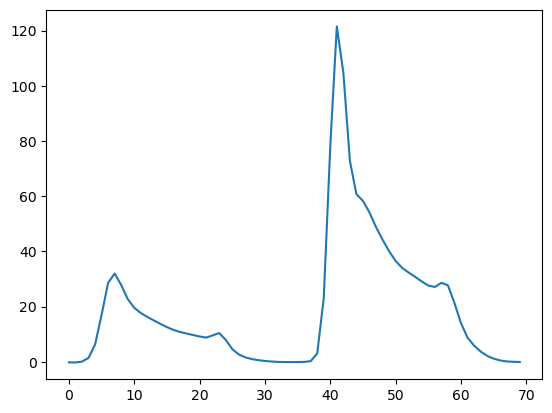

In [21]:
# create the local folder
folder_path = r"C:\ACME_Zhen_Code\Enr\Enr_" + str(run).zfill(4) + "." + str(sequence).zfill(4)
os.makedirs(folder_path, exist_ok=True)

# prefix pattern
prefix = str(run).zfill(4) + "." + str(sequence).zfill(4)

# copy header .txt files
header_src = os.path.join(NAS_drive_name, str(run).zfill(4), "header_data")
for f in glob.glob(os.path.join(header_src, prefix + "*.txt")):
    shutil.copy2(f, folder_path)

# copy detector .bin files
detector_src = os.path.join(NAS_drive_name, str(run).zfill(4), "all_detectors")
for f in glob.glob(os.path.join(detector_src, prefix + "*.bin")):
    shutil.copy2(f, folder_path)

binpara_base = {
  "bin_mask": [
    1,
    1,
    1,
    1
  ],
  "bin_size": 70,
  "bin_offset": 26,
  "background_begin_time_ms": 0,
  "background_end_time_ms": 4,
  "background_average_level": "trace",
  "background_D_mode": "equal",
  "noisechannel": [],
  "noisechannel_substraction": False,
  "group_size": 20,
  "sum_shot": True,
  "ACMEIII_header_purge": True,
  "trace_already_summed": True,
  "file_dtype": "int32",
  "info_header_length": 2,
  "channel_weight": [
    -0.03963429,
    -0.03918644,
    -0.03918644,
    -0.04009249,
    -0.03986207,
    -0.03853333,
    -0.0387486,
    -0.0387486
  ]
}

binpara_base.update(binpara)



# save the binpara to json
parameter_file_path = os.path.join(folder_path, "binpara_" + prefix + ".json")
with open(parameter_file_path, 'w') as f:
    json.dump(binpara_base, f, indent=4)

# get headers

df_header = hh.headerHandler([folder_path])
df_header = df_header[["run", "sequence","block", "trace", "Microwave_freq", "Microwave_freq_offset", "E", "L"]]
df_header = df_header[df_header['Microwave_freq_offset'] == 0]
df_header = df_header.reset_index(drop = True).reset_index()
# get binary files 

bin_files = sorted(glob.glob(os.path.join(folder_path, "*.bin")))
res_list = []
for bin_file in bin_files:
    a = binCalculator(bin_file, 
                  parameter_file_path, 
                  pd.DataFrame({'Polarization Switching XY Swapped':[0,0,0,0,0]}))
    a.default_pipeline()
    res = ((a.binresult.A /a.binresult.dA2_from_photon).sum(axis = 2,keepdims = True)/(1/a.binresult.dA2_from_photon).sum(axis = 2, keepdims = True)).squeeze()
    res_list.append(res)

fig, ax = plt.subplots()
ax.plot(a.binresult.bin_pair_inspection_data.mean(axis = 0))
fig.savefig(os.path.join(folder_path, "bin_pair_inspection_" + prefix + ".png"))
data = np.concatenate(res_list, axis = 0)

bg_substracted_data = data[0::2,:] - data[1::2,:]

index_min = df_header.reset_index().groupby(["E", "L"])["index"].min().to_dict()
index_max = df_header.reset_index().groupby(["E", "L"])["index"].max().to_dict()
EL_data = {}
for (E, L), idx_min in index_min.items():
    idx_max = index_max[(E, L)]
    EL_data[(E, L)] = bg_substracted_data[idx_min:idx_max+1,:]


freq_center = df_header['Microwave_freq'].mean()
freqs = sorted(df_header['Microwave_freq'].unique()) - freq_center

import numpy as np
from scipy.optimize import curve_fit

def gauss(x, A, x0, sigma):
    return A * np.exp(-0.5 * ((x - x0) / sigma) ** 2)


EL_centers = {}
EL_sigmas = {}


for E, L in [(-1,-1), (-1,1), (1,-1), (1,1)]:
    data = EL_data[(E,L)]
    EL_centers[(E,L)] = np.zeros(data.shape[1])
    EL_sigmas[(E,L)]  = np.zeros(data.shape[1])

    centers = EL_centers[(E,L)]
    sigmas  = EL_sigmas[(E,L)]



    for j in range(data.shape[1]):

        y = data[:, j]
        x = freqs

        # --- Step 1: find peak location (by abs)
        idx_peak = np.argmax(np.abs(y))
        y_peak = y[idx_peak]

        # --- Step 2: find FWHM boundaries (on abs(y))
        half_val = 0.5 * np.abs(y_peak)
        abs_y = np.abs(y)

        # Search left and right for first crossings below half max
        left_idx = idx_peak
        while left_idx > 0 and abs_y[left_idx] > half_val:
            left_idx -= 1
        right_idx = idx_peak
        while right_idx < len(abs_y) - 1 and abs_y[right_idx] > half_val:
            right_idx += 1

        # Compute sigma from FWHM ~ 2.355 * sigma
        fwhm = freqs[right_idx] - freqs[left_idx] if right_idx > left_idx else 0
        sigma_est = fwhm / 2.355 if fwhm > 0 else (freqs[1] - freqs[0]) * 2

        # --- Step 3: define 2-sigma fitting range
        mask = (freqs >= freqs[idx_peak] - 2 * sigma_est) & (freqs <= freqs[idx_peak] + 2 * sigma_est)
        x_fit = x[mask]
        y_fit = y[mask]

        # --- Step 4: initial guesses
        p0 = [y_peak, freqs[idx_peak], sigma_est]

        # --- Step 5: perform Gaussian fit (no offset)
        try:
            popt, _ = curve_fit(gauss, x_fit, y_fit, p0=p0)
            _, xc, sc = popt
        except:
            xc, sc = np.nan, np.nan

        centers[j] = xc
        sigmas[j]  = abs(sc)





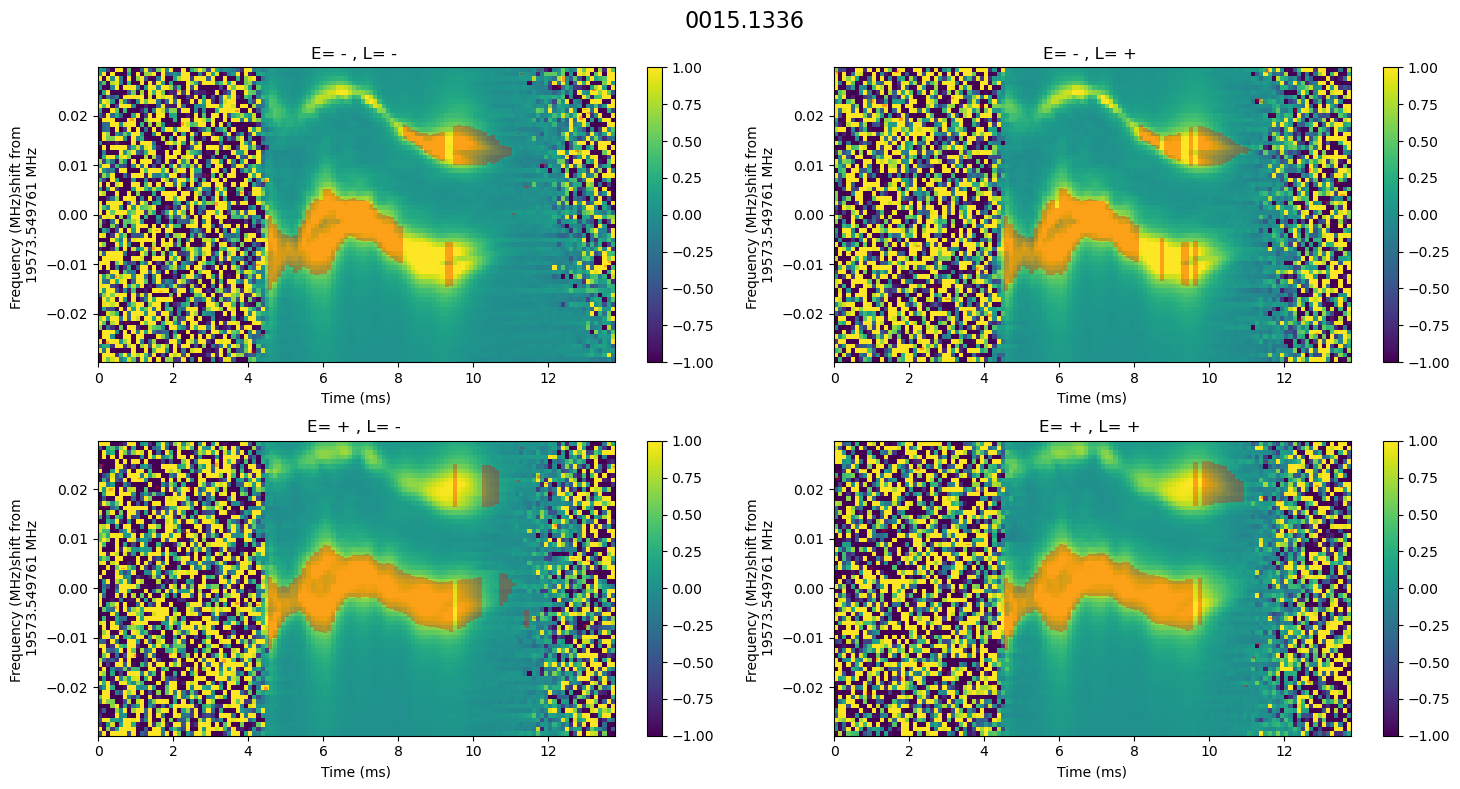

In [22]:
fig, axes = plt.subplots(2,2, figsize=(15, 8))
time_per_col_ns = binpara_base["bin_size"] * binpara_base["group_size"] * 80  # ns
time_axis_ms = np.arange(data.shape[1]) * time_per_col_ns * 1e-6  # convert ns → ms

axes_ref = {(-1,-1) : axes[0,0],
            (-1, 1) : axes[0,1],
            ( 1,-1) : axes[1,0],
            ( 1, 1) : axes[1,1]}

for E,L in [(-1,-1), (-1,1), (1,-1), (1,1)]:
    data = EL_data[(E,L)]
    im = axes_ref[(E,L)].imshow(
        data,
        extent=[time_axis_ms[0], time_axis_ms[-1], freqs[0], freqs[-1]],
        origin='lower',
        aspect='auto',
        vmin=-1,
        vmax=1
    )
    plt.colorbar(im, ax=axes_ref[(E,L)])
    # 2. overlay ±1 sigma regions (semi-transparent red)
    for j, (c, s) in enumerate(zip(EL_centers[(E,L)], EL_sigmas[(E,L)])):
        if np.isnan(c) or np.isnan(s):
            continue
        y1 = c - s
        y2 = c + s
        # each column corresponds to one time value (width = time step)
        if j < len(time_axis_ms) - 1:
            dt = time_axis_ms[j + 1] - time_axis_ms[j]
        else:
            dt = time_axis_ms[j] - time_axis_ms[j - 1]
        rect = Rectangle(
            (time_axis_ms[j] - dt / 2, y1),
            dt,
            y2 - y1,
            color='red',
            alpha=0.3,
            lw=0
        )
        axes_ref[(E,L)].add_patch(rect)

    axes_ref[(E,L)].set_xlabel('Time (ms)')
    axes_ref[(E,L)].set_ylabel('Frequency (MHz)'+ "shift from "+'\n' + str(freq_center)[:12] + " MHz")
    if E == -1:
        E_str = ' - '
    else:
        E_str = ' + '
    
    if L == -1:
        L_str = ' - '
    else:
        L_str = ' + '
    axes_ref[(E,L)].set_title(f'E={E_str}, L={L_str}')
fig.suptitle(str(run).zfill(4)+"."+str(sequence).zfill(4), fontsize=16)
fig.tight_layout()
fig.savefig(os.path.join(folder_path, f"EL_2dmap_"+str(run).zfill(4)+"."+str(sequence).zfill(4)+".png"), dpi=600)

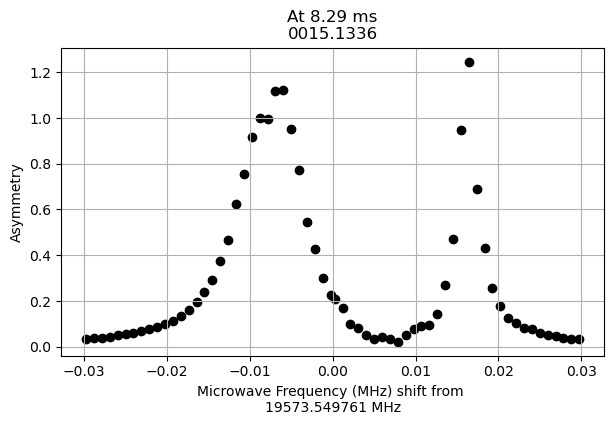

In [23]:
fig, ax = plt.subplots(figsize=(7,4))
ax.scatter(freqs, EL_data[(-1,-1)][:,int(len(time_axis_ms)*0.6)],color = "k")
ax.grid(True)
ax.set_ylabel("Asymmetry")
ax.set_xlabel("Microwave Frequency (MHz)"+ " shift from "+'\n' + str(freq_center)[:12] + " MHz")
# set title tells ms of data used and run and sequence
ax.set_title(f"At {time_axis_ms[int(len(time_axis_ms)*0.6)]:.2f} ms" +"\n"+ str(run).zfill(4)+"."+str(sequence).zfill(4))
fig.savefig(os.path.join(folder_path, f"EL_linecut_"+str(run).zfill(4)+"."+str(sequence).zfill(4)+".png"), dpi=600)

In [24]:
freq_E = (EL_centers[(1,-1)] - EL_centers[(-1,-1)] + EL_centers[(1,1)] - EL_centers[(-1,1)])/4
freq_L = (EL_centers[(-1,1)] - EL_centers[(-1,-1)] + EL_centers[(1,1)] - EL_centers[(1,-1)])/4
freq_EL = (EL_centers[(1,1)] + EL_centers[(-1,-1)] - EL_centers[(1,-1)] - EL_centers[(-1,1)])/4

E_nr = freq_E / 1.06 *1000
E_L = freq_EL / 1.06 *1000
E_EL = freq_L / 1.06 *1000

time_beam = np.arange(len(a.binresult.bin_pair_inspection_data[:,0]))*binpara_base["bin_size"]*80/1e6

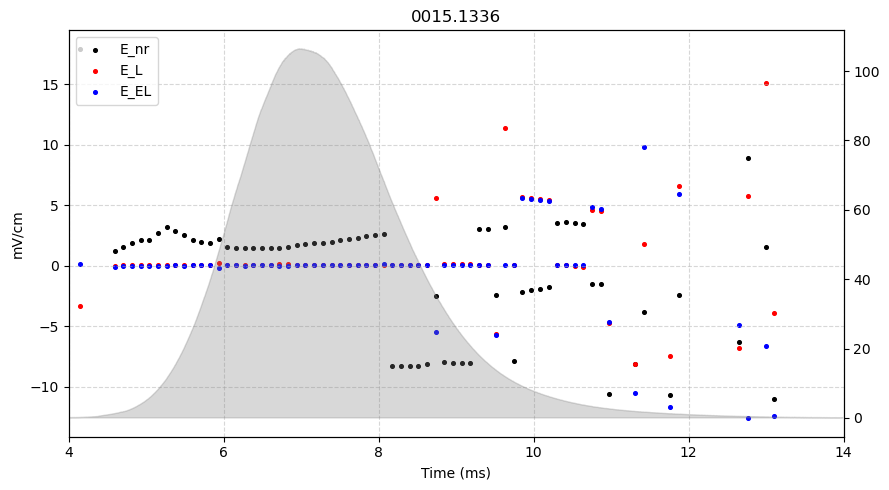

In [25]:

fig, ax = plt.subplots(figsize=(9, 5))

# === Left y-axis: three energy curves ===
ax.scatter(time_axis_ms, E_nr, s = 7 ,color='black', label='E_nr')
ax.scatter(time_axis_ms, E_L,  s = 7 ,color='red',   label='E_L')
ax.scatter(time_axis_ms, E_EL, s = 7 ,color='blue',  label='E_EL')

ax.set_xlabel('Time (ms)')
ax.set_ylabel('mV/cm')
ax.grid(True, which='both', linestyle='--', alpha=0.5)
ax.legend()
ax.set_xlim(4,14)
# === Right y-axis: shaded background ===
ax2 = ax.twinx()
shade_y = a.binresult.bin_pair_inspection_data.mean(axis=1)
ax2.fill_between(time_beam, shade_y, color='gray', alpha=0.3, label='Bin Pair Inspection')

# === Legend and formatting ===
ax.legend(loc='upper left')
ax.set_title(str(run).zfill(4)+"."+str(sequence).zfill(4))

fig.tight_layout()
fig.savefig(os.path.join(folder_path, f"Enr_plot_"+str(run).zfill(4)+"."+str(sequence).zfill(4)+".png"), dpi=600)

In [26]:
# deletion of .bin and .txt files in the folder_path

folder_path = r"C:\ACME_Zhen_Code\Enr\Enr_" + str(run).zfill(4) + "." + str(sequence).zfill(4)

for f in glob.glob(os.path.join(folder_path, '*.bin')):
    os.remove(f)
for f in glob.glob(os.path.join(folder_path, '*.txt')):
    os.remove(f)